# Reducing Astronomical Image Data

Congratulations, you got your data off the telescope! Now what? In this notebook we'll learn some basic techniques for reducing astronomical images.

Unlike images from consumer cameras or phones, which usually come in a bitmapped formt like jpeg, gif, tiff, or png, astronomical images are typically returned in a format called Flexible Image Transfer System, or FITS for short. A full description of the [FITS data format](https://fits.gsfc.nasa.gov/fits_primer.html) is beyond the scope of this notebook. But a basic FITS file of the kind produced by the Lucy telescopes consists of a single entity called a HDU (header data unit), which as the name implies consists of two parts:
* A <b>header</b>, which is a set of key-value pairs that contain metadata about the image. This might include the start and end time of the exposure, the telescope pointing coordinates, GPS information, environmental conditions, camera status, names of the observers, etc. Additional information can be added to the header as the data is processed. 
* A <b>data</b> block, which is a 2-dimensional array indexed by the row and column of each pixel. Each array element contains the number of counts recorded in that pixel during the exposure. 

The most widespread tool for viewing FITS images is the program [<tt>ds9</tt>](https://sites.google.com/cfa.harvard.edu/saoimageds9). There are versions for all platforms and it should be part of every astronomer's toolkit. In this notebook we'll make basic plots using python's matplotlib.

Raw image data, however, is not very useful for doing science. The set of steps that we take to go from pixels and counts to objects like stars and galaxies in a celestial coordinate system, with calibrated fluxes and magnitudes, is called a data reduction pipeline. The exact steps vary in detail and complexity depending on the application, but every pipeline has several elements in common:
* <b> Source extraction</b>: Recognizing which groups of pixels belong to a single object (e.g. a star) and determining their position and flux. The places where sources are _not_ helps us identify the number of counts that come from backgrounds -- e.g. sky brightness, camera noise, etc. 
* <b> Astrometric calibration</b>: Matching the sources to a reference catalog (e.g. Gaia) to determine the (nonlinear) mapping from pixel coordinates (i,j) to sky coordinates (ra, dec). We also call this "plate solving", which is a charming anachronism that dates from the time when astronomical images were photographs on actual glass plates.
* <b> Flux calibration</b>: Converting "counts" to a physical scale, such as magnitude.

The last step is important for many applications, but not for occultations: we just want to know if the star was there or not! So in this notebook we will focus on source identification and astrometric calibration.


In [151]:
# Import the packages we need:

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import astropy.units as u
from astropy.visualization import SqrtStretch, LinearStretch, SinhStretch, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize
%matplotlib inline

## Displaying a fits image

We will illustrate the pipeline with the very first file in the sequence collected by my team during the Polymele occultation, called `frame_00001.fits`. 

As mentioned above, <tt>ds9</tt> is a powerful tool for displaying and analyzing images like this. But let's show the basic idea by opening it with astropy and displaying it with matplotlib.

The next step uses astropy's fits utility to open the file.

In [152]:
fitsfile_in = '../fitsdata/frame_00001.fits'
hdu = fits.open(fitsfile_in)

Next we extract the header portion of the file and print out the key-value pairs it contains. Take a moment to look these over.

In [153]:
hdr = hdu[0].header
print(repr(hdr))

SIMPLE  =                    T / C# FITS: 02/04/2023 01:41:22                   
BITPIX  =                   16                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 1920                                                  
NAXIS2  =                 1200                                                  
GPS_SEQ =                14191 / Sequence Number                                
GPS_TMP =                    1 / TempSequenceNum                                
GPS_W   =                 1936 / Width                                          
GPS_H   =                 1024 / Height                                         
GPS_LAT =            38.369187 / Latitude                                       
GPS_LONG=    -97.5379793333333 / Longitude                                      
GPS_SFLG=                   51 / StartFlag                                      
GPS_ST  = '2023-02-04T01:41:

In [154]:
# You can print an individual value by referencing its keyword:
exp_start = hdr['DATE-OBS']
exptime = hdr['EXPTIME']
lat, lon = hdr['GPS_LAT'], hdr['GPS_LONG']

print(f'Exposure start time and duration: {exp_start}, {exptime}')
print(f'GPS lat, lon: {lat}, {lon}')

Exposure start time and duration: 2023-02-04T01:41:19.0531223, 0.2
GPS lat, lon: 38.369187, -97.5379793333333


In [155]:
# Now the image data
data = hdu[0].data
height, width = data.shape
print(f'Image dimensions: {width}, {height}')

Image dimensions: 1920, 1200


The data is a 2d array with dimensions 1200 x 1920 pixels. You can also see this in the header, in the `NAXIS`, `NAXIS1`, and `NAXIS2` keywords.

It will also be useful to extract a smaller region from the center of the image, where our target star is located.

In [156]:
cutout = data[510:910,730:1230]

Each element of the data array contains a value which represents the number of counts in that pixel. Counts come from a variety of sources: the baseline offset in the camera, noise, ambient sky brightness, and of course astronomical objects in our image. We can make a simple histogram of these values:

5152.0 1977.1183225409607


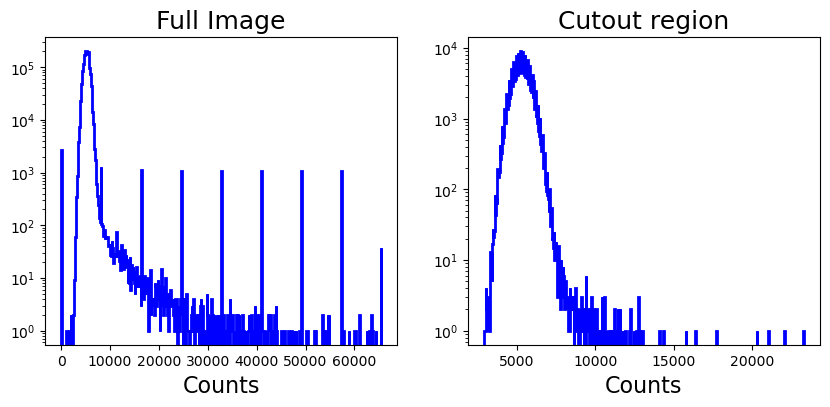

In [157]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
n, bins, _ = ax1.hist(data.ravel(), bins=500, histtype='step', color='b', lw=2)
ax1.semilogy()
ax1.set_xlabel('Counts', fontsize=16)
ax1.set_title('Full Image', fontsize=18)
n, bins, _ = ax2.hist(cutout.ravel(), bins=500, histtype='step', color='b', lw=2)
ax2.semilogy()
ax2.set_xlabel('Counts', fontsize=16)
ax2.set_title('Cutout region', fontsize=18)
median, std = np.median(data), np.std(data)
print(np.median(data), np.std(data))

The series of spikes with high count numbers in the full image is noise at one edge of the chip. This is far from the target star, they don't appear in the cutout region.

You can see from both distributions above that the image has a large dynamic range. If we try to visualize the data on a simple linear scale, it can be hard to see many features. There are many re-mappings, called "stretch functions" that can mitigate this. Some of them are imported at the beginning of this noteboook and you can play around with them if you want. We will do the simplest thing, which is to apply a cut that gets us the main distribution centered near 5000 counts, using the mean and standard deviations computed in the last lines above.

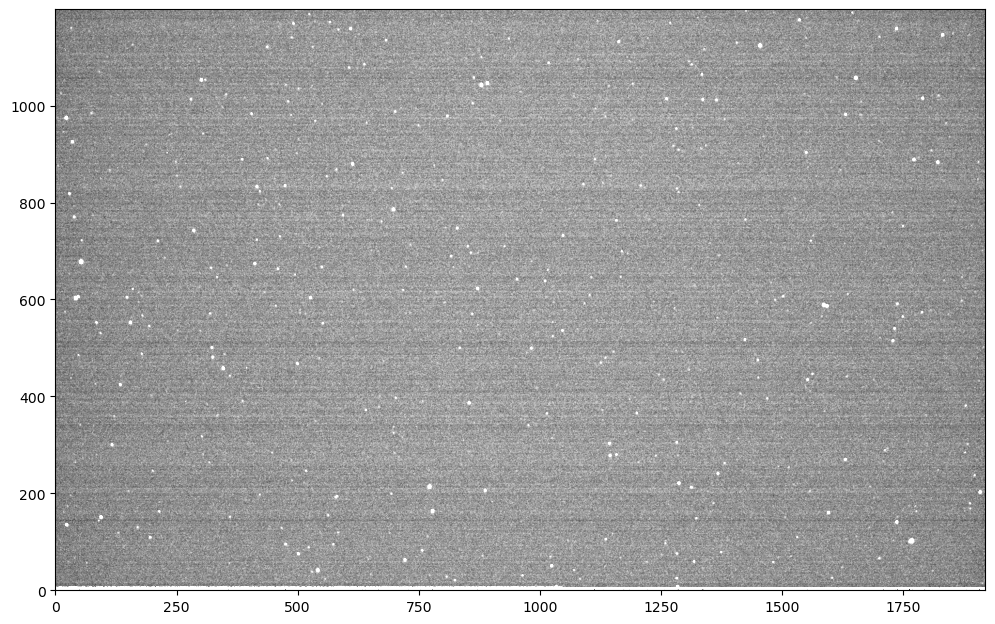

In [158]:
# plot the data:

fig, ax = plt.subplots(1, figsize=(12,8))
# This next step may take some hand-tuning.
norm = ImageNormalize(vmin=median-std, vmax=median+std, stretch=LinearStretch())
ax.imshow(data, cmap='Greys_r', origin='lower', norm=norm,
           interpolation='bilinear')

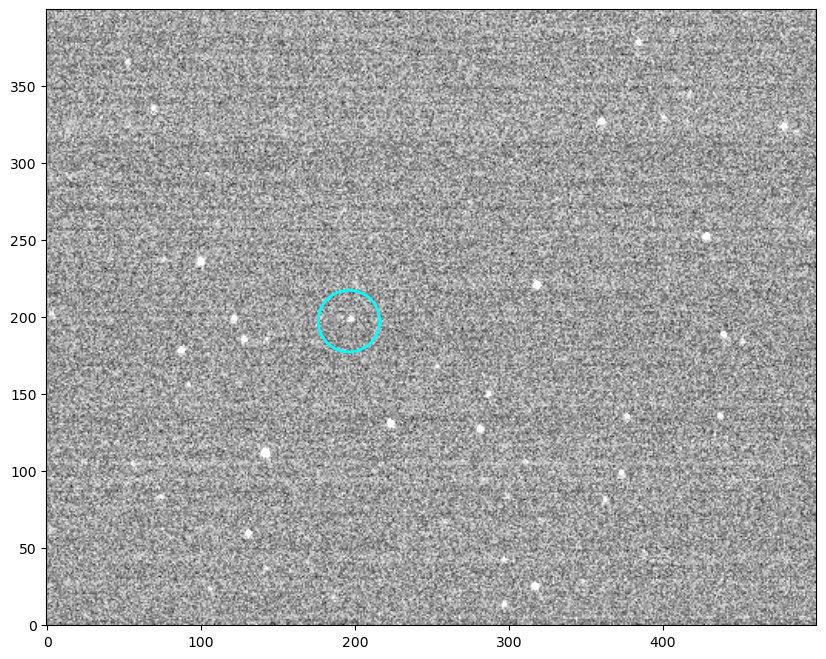

In [159]:
# We can also zoom in on the central cutout region which contains our target star
starx, stary = 196, 197
fig, ax = plt.subplots(1, figsize=(12,8))
target = Circle((starx, stary), radius=20, edgecolor='cyan', fill=False, lw=2 )
ax.imshow(cutout, cmap='Greys_r', origin='lower', norm=norm,
           interpolation='bilinear')
ax.add_patch(target)

If you spent a long time staring at this field and the finder charts, you might recognize "our" star as the one near (196, 197). But right now it's just counts in pixels. It's time to move on to...

# Source extraction

Find the stars and galaxies in this image... it sounds simple. But it's a subtle and not even completely well-defined problem. Where is the "edge" of a diffuse object like a galaxy? When two stars overlap closely, how much flux in a given pixel should be attributed to each object? When does it become impossible to tell a very faint star from a upward fluctuation in the background? There's no single correct answer to these questions, but there are some [canonical](https://www.astromatic.net/software/sextractor/) [approaches](http://thetractor.org/). Python's [`photutils`](https://photutils.readthedocs.io/) package provides a good starting point that works fine for applications like ours. Most of the code below is adapted from the examples in the photutils documentation.

In [160]:
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
import numpy as np

You can think of a "source" as a group of pixels with counts above the background level. The next line provides an estimate of that background. The "sigma clipping" iteratively rejects pixels with counts that are more than a given number of standard deviations from the mean. This provides a good estimate of what's going on in the "average" pixel with no source in it.

In [161]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))  

(5158.734212235731, 5152.0, 558.1590011703839)


Now it's a really simple step to find the sources:

In [162]:
daofind = DAOStarFinder(fwhm=3.0, threshold=4.*std)
sources = daofind(cutout - median)
print(f'Found {len(sources)} sources')

Found 33 sources


DAODtarFinder returns sources as an astropy table, which can be displayed nicely in a Jupyter notebook:

In [163]:
sources.show_in_notebook()

idx,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,317.4373855171791,24.940432751054754,0.45083996788073527,-0.6377929795704523,-0.002751361873250955,25,0.0,6640.0,2.1276182661617558,-0.8197342754919185
1,2,375.9182019441937,28.958047201952933,0.6814420440330432,-0.13651798982674251,0.24641196653667033,25,0.0,2192.0,1.0120719839215333,-0.013028507317044538
2,3,142.20812532288582,36.26728383289158,0.5988787300700111,-0.559665050551023,-0.9847779225576601,25,0.0,2576.0,1.025109731099426,-0.02692589045571713
3,4,361.5848299598702,36.65424920365148,0.507476248950662,0.26833276113106996,0.21909366188823345,25,0.0,1616.0,1.0265883203554758,-0.02849079730352619
4,5,131.00452104828247,59.12439828037335,0.5766700718772453,-0.2819389629960124,0.26038151628209366,25,0.0,4912.0,1.5916446524609518,-0.5046152861716982
5,6,75.14923292389234,61.89271485323181,0.6669775250136073,-0.6629443453630741,-0.47415708482268254,25,0.0,2320.0,1.1009112621825925,-0.1043807863086568
6,7,373.2355204419942,98.2579451888004,0.5000306516390279,-0.24960107911196344,0.25632856656748676,25,0.0,4080.0,1.6143943116998258,-0.5200240466595393
7,8,142.1758479406736,111.78731077828037,0.4304701330544055,-0.22935482612804067,0.007372670268722921,25,0.0,18192.0,6.890015560449309,-2.095550506804493
8,9,94.03219684558337,115.95684838889849,0.23317856280184887,0.4436888469502469,-0.7714469824146805,25,0.0,912.0,1.0005102065024423,-0.0005538084052903
9,10,281.25681029722176,127.06489919454596,0.40004577064310515,-0.051722970165226825,-0.2550533435546788,25,0.0,5808.0,2.0597071646608778,-0.7845136992092566


Notice that the last column (`mag`) displays some very unphysical values. That's because the flux has not yet been calibrated to a physical scale.

Let's plot the sources identified in our central cutout region:


(5277.8331516305525, 5280.0, 554.9624919652314)


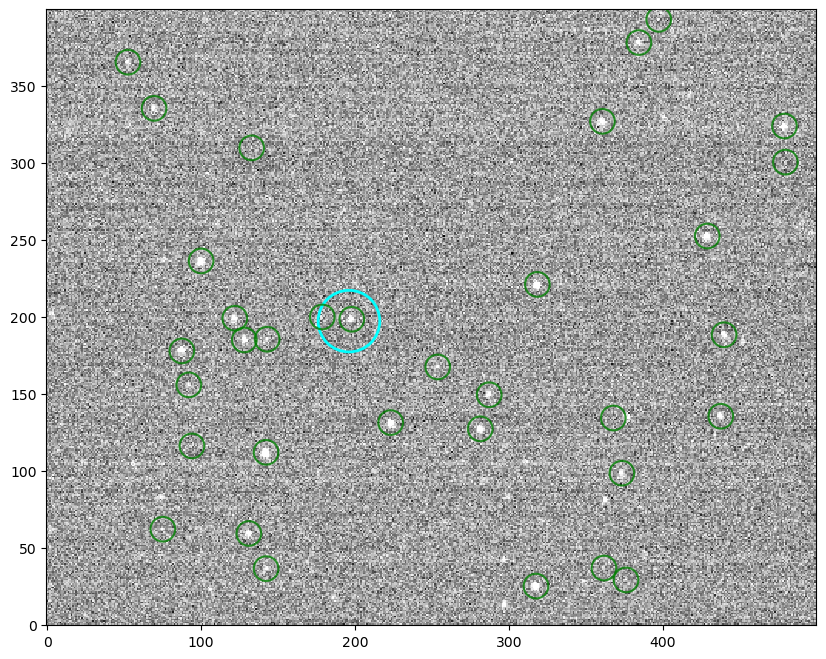

In [164]:
mean, median, std = sigma_clipped_stats(cutout, sigma=3.0)  
print((mean, median, std))  
daofind = DAOStarFinder(fwhm=3.0, threshold=4.*std)
sources_cutout = daofind(cutout - median) 

fig, ax = plt.subplots(1, figsize=(12,8))
target = Circle((starx, stary), radius=20, edgecolor='cyan', fill=False, lw=2 )
ax.imshow(cutout, cmap='Greys_r', origin='lower', norm=norm,
           interpolation='nearest')
ax.add_patch(target)

positions = np.transpose((sources_cutout['xcentroid'], sources_cutout['ycentroid']))
cutout_apertures = CircularAperture(positions, r=8.0)
aps = cutout_apertures.plot(color='green', lw=1.5, alpha=0.8)

Looking at the sources it found, you can see that some faint sources were not identified (you can adjust the `threshold` parameter to play with the sensitivity), and there may be a few false identifications, but overall this looks reasonable.

# Astrometric Calibration (Plate-solving)

We've found the sources in our images. But where are they, really? The procedure above locates the sources in pixel coordinates only. The next step in our pipeline is to convert these to (RA, DEC) positions on the sky. We'll use the api interface to [Astrometry.net](https://astrometry.net/) for this. Astrometry.net is a remarkable, extremely general service for astrometrically calibrating arbitrary image data in almost any format. The algorithm is very clever and is described in [this paper](https://arxiv.org/abs/0910.2233). It makes no assumptions about the data source, field of view, image depth, etc. You can use it by uploading an image (which is slow if you have a lot of images to process) or a catalog of sources. Since we've just obtained such a catalog above, we'll use the latter approach, which is significantly faster.

You can access Astrometry.net through its python interface. Fortunately, `astroquery` makes this easy. (We've used the `astroquery` package already to access JPL Horizons and the Gaia catalog.) To make the most efficient use of this interface, you should get an astrometry.net API key: a string of charcters unique to you that is sent along with your request. You can get your own API key by going to the [Astrometry.net website](https://nova.astrometry.net/api_help) and creating a user account. Your API key will then appear in your profile. Next, copy your key to a local config file as described [here](https://astroquery.readthedocs.io/en/latest/astrometry_net/astrometry_net.html#handling-results).

Our goal is to solve for a <b>WCS</b>, which stands for World Coordinate System. This is a set of coeffients that encode the pixel-to-sky transformation. Once we have a WCS we will add it to the FITS header in our original file.

In [165]:
from astroquery.astrometry_net import AstrometryNet
from astropy.wcs import WCS
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.aperture import SkyCircularAperture
from astropy.wcs.utils import skycoord_to_pixel

In [166]:
# We will use the sources in the full image that we found above, 
# and supply the dimensions from the shape of our data array.

ast = AstrometryNet()

# Important: Sources must be sorted in descending order of flux!

sources.sort('flux')
# Reverse to get descending order
sources.reverse()

# The magic happens here:
wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                        width, height,
                                        solve_timeout=120)

# If solve was successful, update our fits header:
if (wcs_header):
    hdr.update(wcs_header)
    print('Solve successful!')

Solving......................Solve successful!


In [167]:
# Now we can add the RA, DEC of our sources to the table:

wcs = WCS(hdr)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
sky_apertures = apertures.to_sky(wcs)

Set MJD-AVG to 59979.070361 from DATE-AVG.
Set MJD-END to 59979.070397 from DATE-END'. [astropy.wcs.wcs]


In [168]:
sources['ra'] = sky_apertures.positions.ra.deg
sources['dec'] = sky_apertures.positions.dec.deg
sources['skycoord'] = sky_apertures.positions

In [169]:
# Now the RA, DEC, and astropy SkyCoords of our sources appears as the last two columns in our table.
sources.show_in_notebook()

idx,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,ra,dec,skycoord
,,,,,,,,,,,,,,"deg,deg"
0,8,142.1758479406736,111.78731077828037,0.4304701330544055,-0.22935482612804067,0.007372670268722921,25,0.0,18192.0,6.890015560449309,-2.095550506804493,99.80162218148564,36.04492190575194,"99.80162218148564,36.04492190575194"
1,25,99.99416530987949,236.0985255830586,0.40254389317964945,-0.20447690975718028,0.3375743508505061,25,0.0,9216.0,3.6689946438047496,-1.4113676943750568,99.7159730527569,36.0883838659396,"99.7159730527569,36.0883838659396"
2,17,87.48802289087848,177.64624235131984,0.5052277685871812,-0.1557497144493051,0.45584647892509705,25,0.0,7088.0,2.7807206507448603,-1.1103934053376012,99.76202909463535,36.08750451192537,"99.76202909463535,36.08750451192537"
3,11,223.08952013688506,131.12509113948013,0.5517338051136408,-0.16345701176816083,0.2858796489715419,25,0.0,7696.0,2.538750845755308,-1.011550202732603,99.77268577436149,35.998791704773694,"99.77268577436149,35.998791704773694"
4,26,428.6745178609965,252.25292200969557,0.6782697919743169,0.4192083098028142,0.11992957605380641,25,0.0,7632.0,2.4988472848159096,-0.99434928838699,99.6456339323978,35.89176902673798,"99.6456339323978,35.89176902673798"
5,20,439.60321211476247,188.16870422905197,0.34242785864837877,-0.7383770378765824,0.14698931009826122,25,0.0,4624.0,2.4442805402498564,-0.9703776255407783,99.69155872018668,35.875920006521156,"99.69155872018668,35.875920006521156"
6,1,317.4373855171791,24.940432751054754,0.45083996788073527,-0.6377929795704523,-0.002751361873250955,25,0.0,6640.0,2.1276182661617558,-0.8197342754919185,99.83526664660717,35.92630292748897,"99.83526664660717,35.92630292748897"
7,10,281.25681029722176,127.06489919454596,0.40004577064310515,-0.051722970165226825,-0.2550533435546788,25,0.0,5808.0,2.0597071646608778,-0.7845136992092566,99.7653531644164,35.96300732300668,"99.7653531644164,35.96300732300668"
8,24,318.3391398028822,220.83526035074928,0.5586145382496464,-0.2586136645160938,0.01950466855788949,25,0.0,6320.0,1.8485799902478648,-0.6670956193821419,99.68862885307928,35.954094126236065,"99.68862885307928,35.954094126236065"


And now we can plot our image using sky coordinates. We don't have to guesstimate the pixel coordinates, we can compute them from our new WCS!

In [170]:
star_pos = SkyCoord(99.727736, 36.024204, frame='icrs', unit=(u.deg, u.deg))
star_pixels = skycoord_to_pixel(star_pos, wcs)
starx, stary = star_pixels[0], star_pixels[1]
print(f'Star centroid in pixel coordinates: {starx}, {stary}')

Star centroid in pixel coordinates: 196.91525800414175, 197.37770040461115


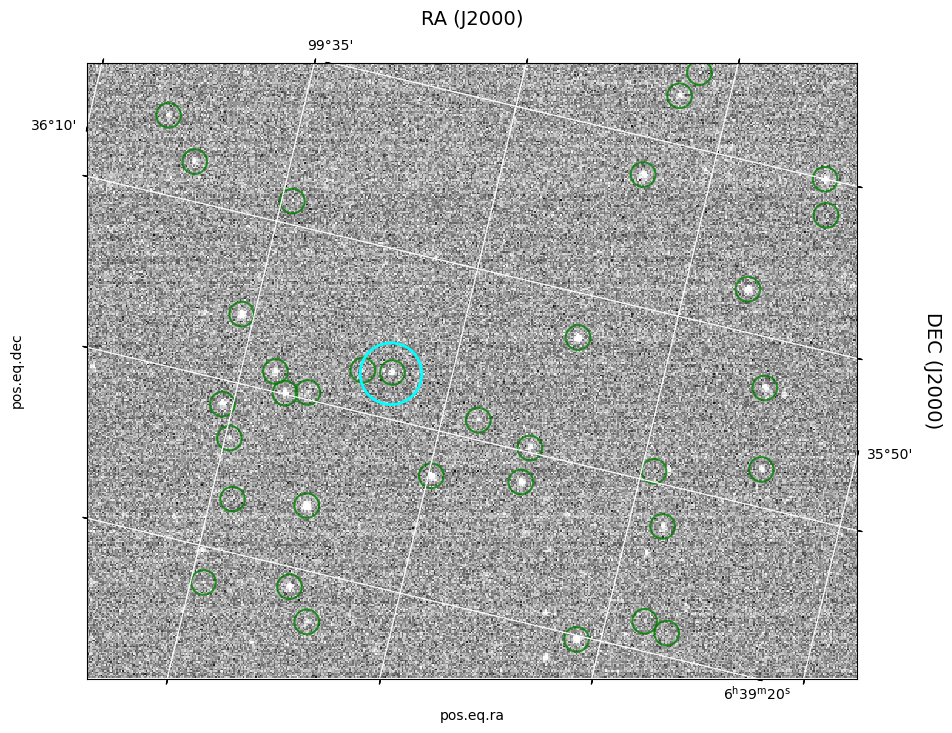

In [171]:
ax = plt.subplot(projection=wcs, label='overlays')

ax.imshow(cutout, cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

ax.coords.grid(True, color='white', ls='solid')

# Plot the identified sources from before
aps = cutout_apertures.plot(color='green', lw=1.5, alpha=0.8)

# Add our target star.
target = Circle((starx, stary), radius=20, edgecolor='cyan', fill=False, lw=2 )
ax.add_patch(target)

overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted')
overlay[0].set_axislabel('RA (J2000)', fontsize=14)
overlay[1].set_axislabel('DEC (J2000)', fontsize=14)

fig = plt.gcf()
fig.set_size_inches(10,8)

# Exercises

Now you'll work with several new FITs files located in the `fitsdata` folder: the image sequence `cutout_669_noWCS.fits`, and `cutout_720_noWCS.fits`, `cutout_740_noWCS.fits`. These were collected with a very different instrument: the Dark Energy Camera on the 4.0-meter Blanco telescope at Cerro Tololo Observatory in Chile. These images reach a depth of around 24th magnitude, about 25,000 times deeper than we achieved with short exposures on the 11-inch Celestron. These images give us a much different view of the universe:

In [172]:
fitsfile_in = '../fitsdata/cutout_699_noWCS.fits'
hdu = fits.open(fitsfile_in)
hdr = hdu[0].header
data = hdu[0].data
height, width = data.shape

median, std = np.median(data), np.std(data)
#n, bins, _ = plt.hist(data.ravel(), bins=np.arange(-100,100, 1), histtype='step')

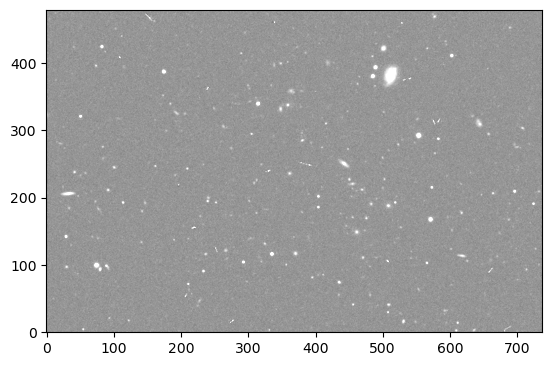

In [173]:
plt.imshow(data, vmin=median-2*std, vmax=median+2*std, cmap='Greys_r', origin='lower', interpolation='bilinear')

Your first goal is to find the sources in each image, and solve for the WCS.
* What new keywords were added to the header as a result of solving for the WCS?

When you've done this, write out updated fits files that contain the WCS information you just computed. You can do this with `hdu.writeto('your_file.fits')`, where `hdu` is the object you opened with the `fits.open()` command.

Your second goal is to identify <b>moving objects</b> in this sequence. I found at least five. It will be easiest to do this by "blinking" the images you just saved using `ds9`. I will show you how to do this. Then answer the following questions:
* What are the coordinates (RA, DEC) of each object in each image?
* Determine the time of each exposure from the `DATE-OBS` keyword in the fits headers.
* What is the approximate rate of motion (in arcseconds per hour) of each object?
* Assume that the on-sky rates of motion are due to earth parallax. That is, assume that the object is stationary and you only need to account for the motion of the earth. What is the approximate distance to each object in AU? It may simplify your calculation to remember that an object at 1 AU, e.g. the sun, has an on-sky rate of motion of about 1 deg / day. You can scale your measured rates accordingly to estimate the distance.)
* Based on the distances you estimated above, what solar system population does each object belong to?